In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import sklearn.metrics as met
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from scipy import signal
import itertools
from collections import deque
from collections import Counter


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [17]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import TimeSeriesSplit

In [4]:
X_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/X_train.txt")
X_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/X_test.txt")
Y_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/y_train.txt")
Y_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/y_test.txt")

X = np.vstack((X_train, X_test))
Y = np.hstack((Y_train, Y_test))

feature_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/features.txt",dtype='str')
label_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/activity_labels.txt", dtype='str')
label_names = [l[1] for l in label_names ]
label_names

transition_label_names=np.array(['ACTIVITIES', 'STAND_TO_SIT',
 'SIT_TO_STAND',
 'SIT_TO_LIE',
 'LIE_TO_SIT',
 'STAND_TO_LIE',
 'LIE_TO_STAND'])

activity_label_names=np.array(['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING',
'TRANSITIONS'])

X_transition_train=X[:int(len(X)*0.6)]
X_transition_validation=X[int(len(X)*0.6):int(len(X)*0.8)]
X_transition_test=X[int(len(X)*0.8):]
Y_transition_train=np.where(Y[:int(len(Y)*0.6)] > 6, Y[:int(len(Y)*0.6)], 0)
Y_transition_validation=np.where(Y[int(len(Y)*0.6):int(len(X)*0.8)] > 6, Y[int(len(Y)*0.6):int(len(X)*0.8)], 0)
Y_transition_test=np.where(Y[int(len(Y)*0.8):] > 6, Y[int(len(Y)*0.8):], 0)

X_activities_train=X[:int(len(X)*0.6)]
X_activities_validation=X[int(len(X)*0.6):int(len(X)*0.8)]
X_activities_test=X[int(len(X)*0.8):]
Y_activities_train=np.where(Y[:int(len(Y)*0.6)] < 7, Y[:int(len(Y)*0.6)], 0)
Y_activities_validation=np.where(Y[int(len(Y)*0.6):int(len(X)*0.8)] < 7, Y[int(len(Y)*0.6):int(len(X)*0.8)], 0)
Y_activities_test=np.where(Y[int(len(Y)*0.8):] < 7, Y[int(len(Y)*0.8):], 0)

In [5]:
train_uid = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/subject_id_train.txt")
test_uid = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/subject_id_test.txt")
user_ids = np.hstack((train_uid, test_uid))
rand_uid=[np.random.choice(np.unique(user_ids), len(np.unique(user_ids)), replace=False) for _ in range(5)]
rand_uid

[array([26., 13., 14.,  3., 12.,  4.,  9.,  5., 29.,  1., 16., 20.,  6.,
         2., 11., 18., 30.,  7.,  8., 15., 24., 25., 22., 28., 23., 21.,
        27., 19., 10., 17.]),
 array([24., 13., 12., 14., 16.,  2.,  1.,  3., 22.,  8.,  7., 29., 11.,
        27.,  6.,  9., 25., 18., 28., 19., 15., 26., 10.,  5., 21., 20.,
        17., 23., 30.,  4.]),
 array([20., 13.,  2., 19.,  6., 29.,  5., 26.,  1., 11., 17., 27., 22.,
         4., 30., 14., 23., 18.,  8.,  7., 10., 12., 21., 25., 24., 16.,
         9., 28., 15.,  3.]),
 array([22., 23., 25.,  5.,  1., 17.,  3., 21., 20., 26., 28.,  7., 11.,
         8., 30., 29., 19.,  2., 24., 12., 16., 15.,  4.,  9., 10.,  6.,
        14., 27., 13., 18.]),
 array([ 4., 16., 14., 29., 26., 17., 19.,  8.,  6., 24., 27., 18., 20.,
        28., 12.,  7.,  3., 22.,  5.,  2., 25.,  9., 13.,  1., 15., 10.,
        11., 23., 30., 21.])]

In [6]:
def one_hot(y, labels):
    Y_onehot=[]
    for l in y:
        empty_label=np.zeros(len(labels))
        empty_label[labels.index(l)]=1.
        Y_onehot.append(empty_label)
    return(np.vstack(Y_onehot))


In [7]:
np.subtract(1., np.array([0.9, 0.8]))

array([0.1, 0.2])

In [8]:
def get_metrics(target, output):
        
        pred = np.round(output)
        
        tp = np.sum(((pred + target) == 2).astype(float), axis=0)
        fp = np.sum(((pred - target) == 1).astype(float), axis=0)
        fn = np.sum(((pred - target) == -1).astype(float), axis=0)
        tn = np.sum(((pred + target) == 0).astype(float), axis=0)

        acc = (tp + tn) / (tp + tn + fp + fn)
        try:
            prec = tp / (tp + fp)
        except ZeroDivisionError:
            prec = 0.0
        try:
            rec = tp / (tp + fn)
        except ZeroDivisionError:
            rec = 0.0
        try:
            specificity = tn / (tn + fp)
        except ZeroDivisionError:
            specificity = 0.0


        try:
            f1=2.*((prec*rec)/(prec+rec))
        except ZeroDivisionError:
            f1 = 0.0
        
        acc[acc != acc] = 0.
        prec[prec != prec] = 0.
        rec[rec != rec] = 0.
        specificity[specificity != specificity] = 0.
        f1[f1 != f1] = 0.
        
        balanced_accuracy = (rec + specificity) / 2.
        
        err_rate = np.subtract(1., acc)
        f1_micro, f1_macro, f1_weight, log_ls, roc = [], [], [], [], []
        for idx in range(target.shape[1]):
            y_test=target[:,idx]
            y_pred=pred[:,idx]
            
            f1_micro.append(f1_score(y_test, y_pred, average= 'micro'))
            f1_macro.append(f1_score(y_test, y_pred, average= 'macro'))
            f1_weight.append(f1_score(y_test, y_pred, average= 'weighted'))
            log_ls.append(log_loss(y_test, y_pred, labels=[0., 1.]))
            try:
                roc.append(roc_auc_score(y_test, output[:, idx]))
            except ValueError:
                roc.append(np.nan)
            
        return (balanced_accuracy, acc, err_rate, prec, rec, specificity, f1, tp, fp, fn, tn, np.array(f1_micro), np.array(f1_macro), np.array(f1_weight), np.array(log_ls), np.array(roc))
    

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    dtype = torch.FloatTensor

In [10]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1

In [11]:
train_inp, train_out = X_transition_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
val_inp, val_out = X_transition_validation, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
test_inp, test_out = X_transition_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])

In [12]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1).cuda()
        self.linear = nn.Linear(hidden_size*num_directions, output_size)
        self.act = nn.Softmax()
        #self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], self.output_size).cuda()
        #pred = nn.Sigmoid(self.linear(pred)).view(pred.data.shape[0], 12)
        return pred

In [15]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_one_hot = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(transition_label_names)+1))
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_t.data.cpu().numpy(), axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((transition_label_names, np.vstack(results_metrics)))))
    with open("timesplit_Transition_classification_results_BiGRU_paper_comp_2.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
    with open("timesplit_Transition_classification_results_BiGRU_paper_comp_2_conf_matrix.csv", 'a') as f:
        pd.DataFrame(np.hstack((transition_label_names.reshape(-1, 1), results_conf_mat))).to_csv(f, header=False)
        
    plt.subplots(figsize=(20,15))
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=transition_label_names, yticklabels=transition_label_names)
    title="Transition Learning"
    s.set_title(title)
    

In [14]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 7
config["num_epochs"] = 5000
config["learning_rate"] = 1e-4

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.0730, device='cuda:0'))
(100, tensor(1.0429, device='cuda:0'))
(200, tensor(1.0367, device='cuda:0'))
(300, tensor(1.0345, device='cuda:0'))
(400, tensor(1.0336, device='cuda:0'))
(500, tensor(1.0331, device='cuda:0'))
(600, tensor(1.0328, device='cuda:0'))
(700, tensor(1.0327, device='cuda:0'))
(800, tensor(1.0325, device='cuda:0'))
(900, tensor(1.0325, device='cuda:0'))
(1000, tensor(1.0324, device='cuda:0'))
(1100, tensor(1.0323, device='cuda:0'))
(1200, tensor(1.0323, device='cuda:0'))
(1300, tensor(1.0323, device='cuda:0'))
(1400, tensor(1.0322, device='cuda:0'))
(1500, tensor(1.0322, device='cuda:0'))
(1600, tensor(1.0322, device='cuda:0'))
(1700, tensor(1.0322, device='cuda:0'))
(1800, tensor(1.0322, device='cuda:0'))
(1900, tensor(1.0322, device='cuda:0'))
(2000, tensor(1.0322, device='cuda:0'))
(2100, tensor(1.0322, device='cuda:0'))
(2200, tensor(1.0321, device='cuda:0'))
(2300, tensor(1.0321, device='cuda:0'))
(2400, tensor(1.0321, device='cuda:0'))
(2500, tenso

(700, tensor(1.2669, device='cuda:0'))
(800, tensor(1.2665, device='cuda:0'))
(900, tensor(1.2662, device='cuda:0'))
(1000, tensor(1.2660, device='cuda:0'))
(1100, tensor(1.2657, device='cuda:0'))
(1200, tensor(1.2656, device='cuda:0'))
(1300, tensor(1.2654, device='cuda:0'))
(1400, tensor(1.2653, device='cuda:0'))
(1500, tensor(1.2652, device='cuda:0'))
(1600, tensor(1.2651, device='cuda:0'))
(1700, tensor(1.2650, device='cuda:0'))
(1800, tensor(1.2650, device='cuda:0'))
(1900, tensor(1.2649, device='cuda:0'))
(2000, tensor(1.2649, device='cuda:0'))
(2100, tensor(1.2649, device='cuda:0'))
(2200, tensor(1.2648, device='cuda:0'))
(2300, tensor(1.2648, device='cuda:0'))
(2400, tensor(1.2648, device='cuda:0'))
(2500, tensor(1.2648, device='cuda:0'))
(2600, tensor(1.2648, device='cuda:0'))
(2700, tensor(1.2648, device='cuda:0'))
(2800, tensor(1.2647, device='cuda:0'))
(2900, tensor(1.2647, device='cuda:0'))
(3000, tensor(1.2647, device='cuda:0'))
(3100, tensor(1.2647, device='cuda:0'))
(32

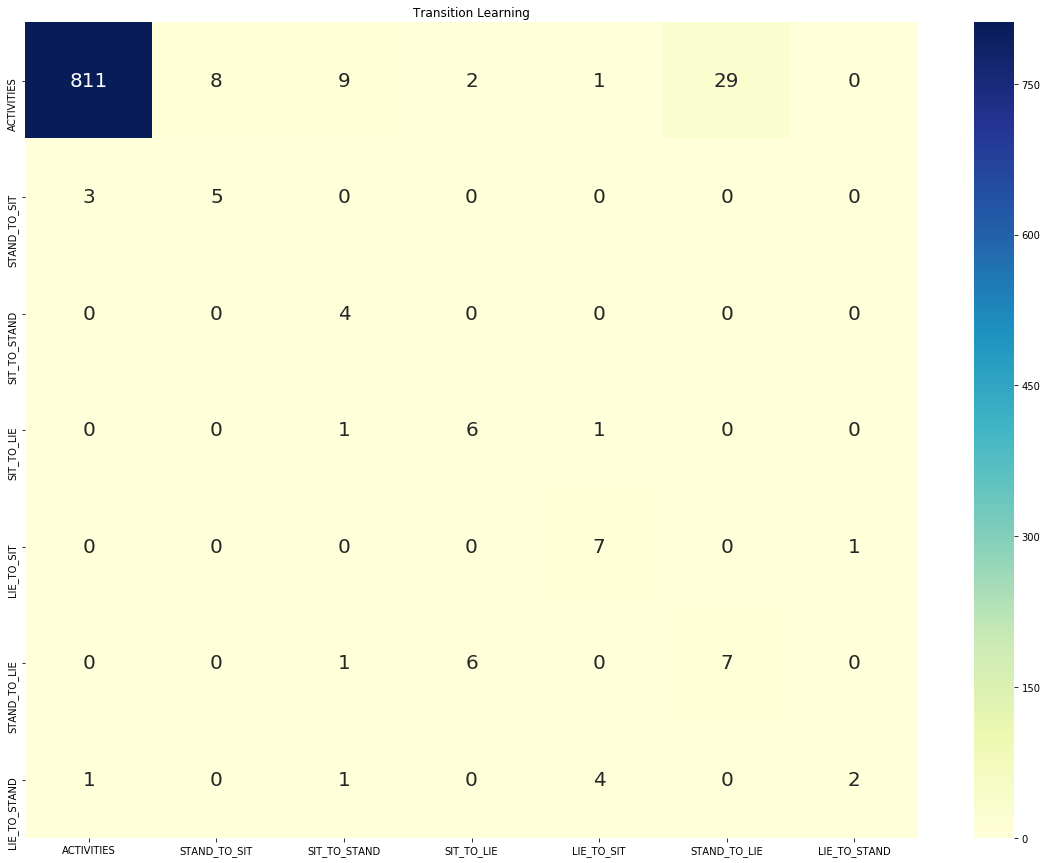

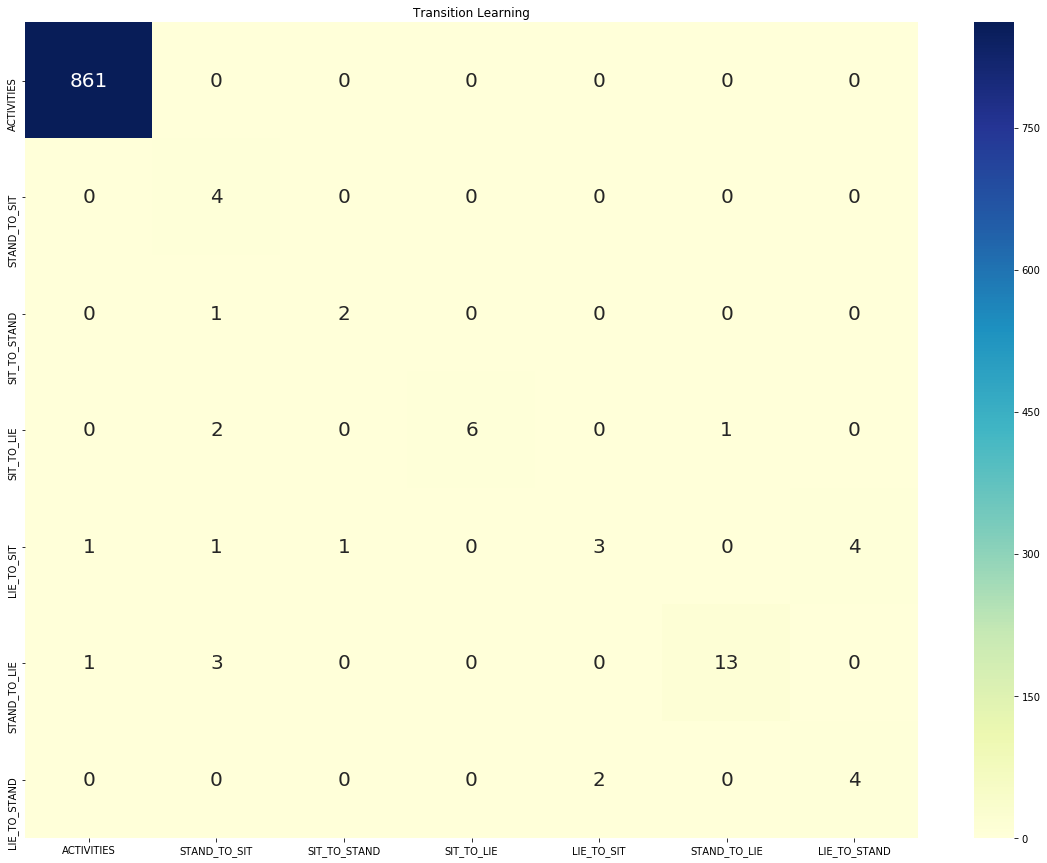

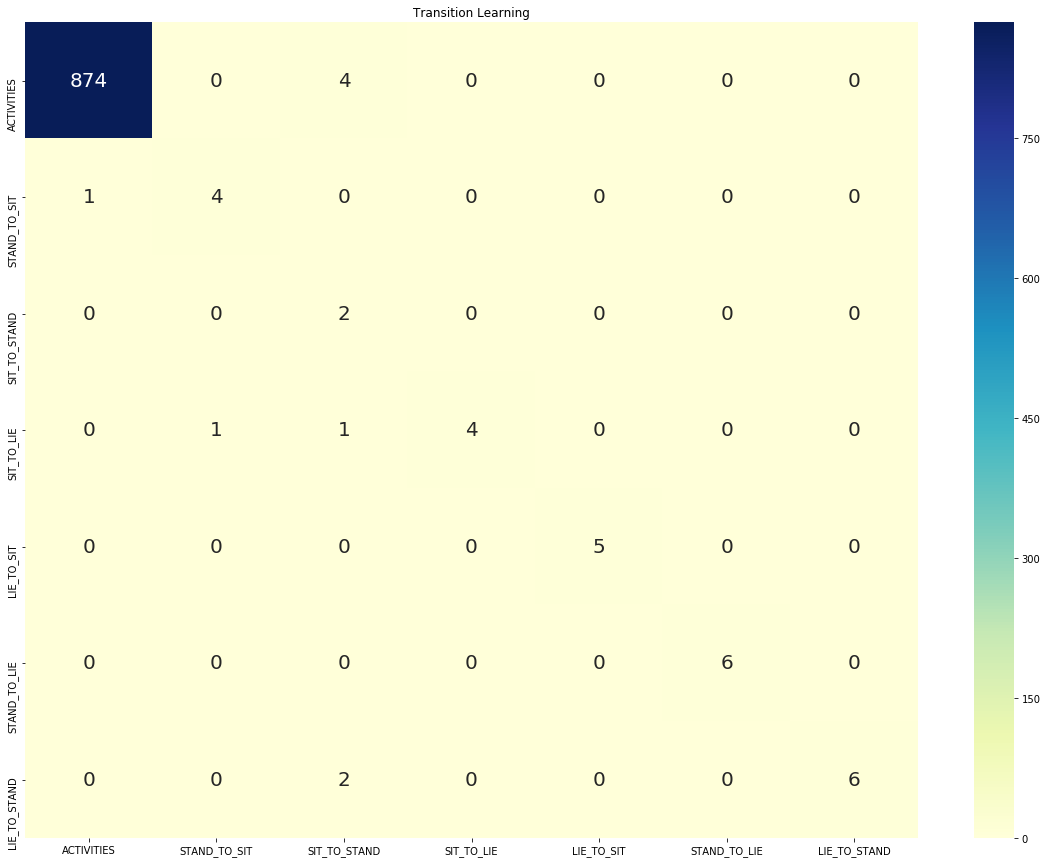

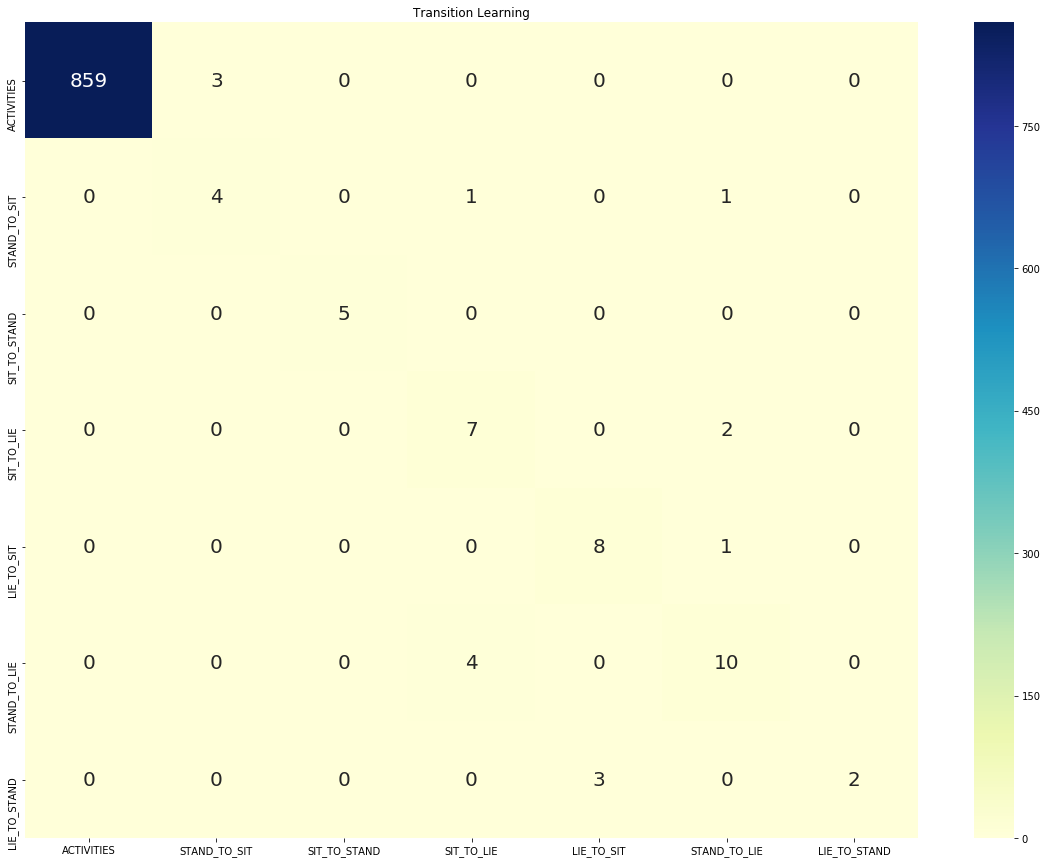

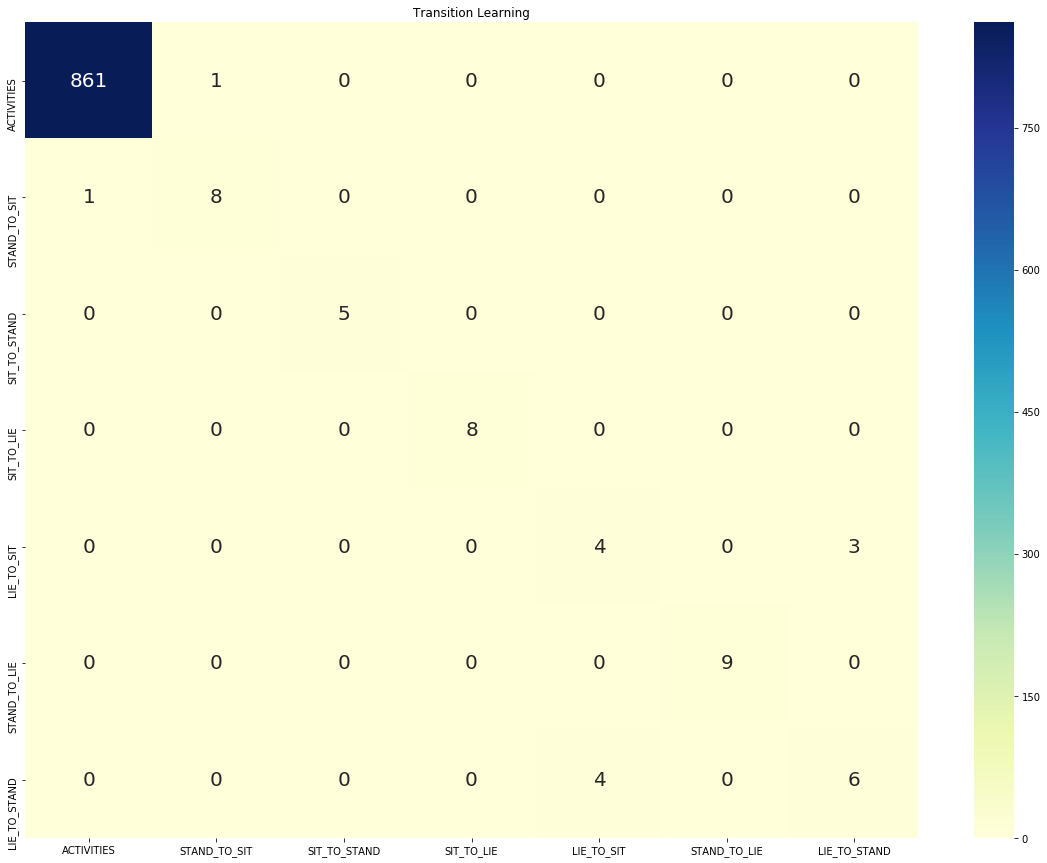

In [18]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index )
    X_train, X_test, X_val = X[train_index], X[test_index[int(len(test_index)*0.5):]], X[test_index[:int(len(test_index)*0.5)]]
    Y_train, Y_test, Y_val = Y[train_index], Y[test_index[int(len(test_index)*0.5):]], Y[test_index[:int(len(test_index)*0.5)]]
    Y_transition_train=np.where(Y_train > 6, Y_train, 0)
    Y_transition_validation=np.where(Y_val > 6, Y_val, 0)
    Y_transition_test=np.where(Y_test > 6, Y_test, 0)
    Y_activities_train=np.where(Y_train < 7, Y_train, 0)
    Y_activities_validation=np.where(Y_val < 7, Y_val, 0)
    Y_activities_test=np.where(Y_test < 7, Y_test, 0)
    train_inp, train_out = X_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
    val_inp, val_out = X_val, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
    test_inp, test_out = X_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])
    
    train_gru(config, train_inp, train_out, val_inp, val_out)

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.2594, device='cuda:0'))
(100, tensor(1.2321, device='cuda:0'))
(200, tensor(1.2274, device='cuda:0'))
(300, tensor(1.2253, device='cuda:0'))
(400, tensor(1.2242, device='cuda:0'))
(500, tensor(1.2233, device='cuda:0'))
(600, tensor(1.2227, device='cuda:0'))
(700, tensor(1.2223, device='cuda:0'))
(800, tensor(1.2219, device='cuda:0'))
(900, tensor(1.2216, device='cuda:0'))
(1000, tensor(1.2213, device='cuda:0'))
(1100, tensor(1.2211, device='cuda:0'))
(1200, tensor(1.2210, device='cuda:0'))
(1300, tensor(1.2209, device='cuda:0'))
(1400, tensor(1.2208, device='cuda:0'))
(1500, tensor(1.2207, device='cuda:0'))
(1600, tensor(1.2206, device='cuda:0'))
(1700, tensor(1.2206, device='cuda:0'))
(1800, tensor(1.2206, device='cuda:0'))
(1900, tensor(1.2205, device='cuda:0'))
(2000, tensor(1.2205, device='cuda:0'))
(2100, tensor(1.2205, device='cuda:0'))
(2200, tensor(1.2204, device='cuda:0'))
(2300, tensor(1.2204, device='cuda:0'))
(2400, tensor(1.2204, device='cuda:0'))
(2500, tenso

(700, tensor(1.2130, device='cuda:0'))
(800, tensor(1.2127, device='cuda:0'))
(900, tensor(1.2124, device='cuda:0'))
(1000, tensor(1.2122, device='cuda:0'))
(1100, tensor(1.2120, device='cuda:0'))
(1200, tensor(1.2119, device='cuda:0'))
(1300, tensor(1.2118, device='cuda:0'))
(1400, tensor(1.2117, device='cuda:0'))
(1500, tensor(1.2116, device='cuda:0'))
(1600, tensor(1.2116, device='cuda:0'))
(1700, tensor(1.2115, device='cuda:0'))
(1800, tensor(1.2115, device='cuda:0'))
(1900, tensor(1.2115, device='cuda:0'))
(2000, tensor(1.2115, device='cuda:0'))
(2100, tensor(1.2114, device='cuda:0'))
(2200, tensor(1.2114, device='cuda:0'))
(2300, tensor(1.2114, device='cuda:0'))
(2400, tensor(1.2115, device='cuda:0'))
(2500, tensor(1.2114, device='cuda:0'))
(2600, tensor(1.2114, device='cuda:0'))
(2700, tensor(1.2114, device='cuda:0'))
(2800, tensor(1.2114, device='cuda:0'))
(2900, tensor(1.2113, device='cuda:0'))
(3000, tensor(1.2113, device='cuda:0'))
(3100, tensor(1.2113, device='cuda:0'))
(32

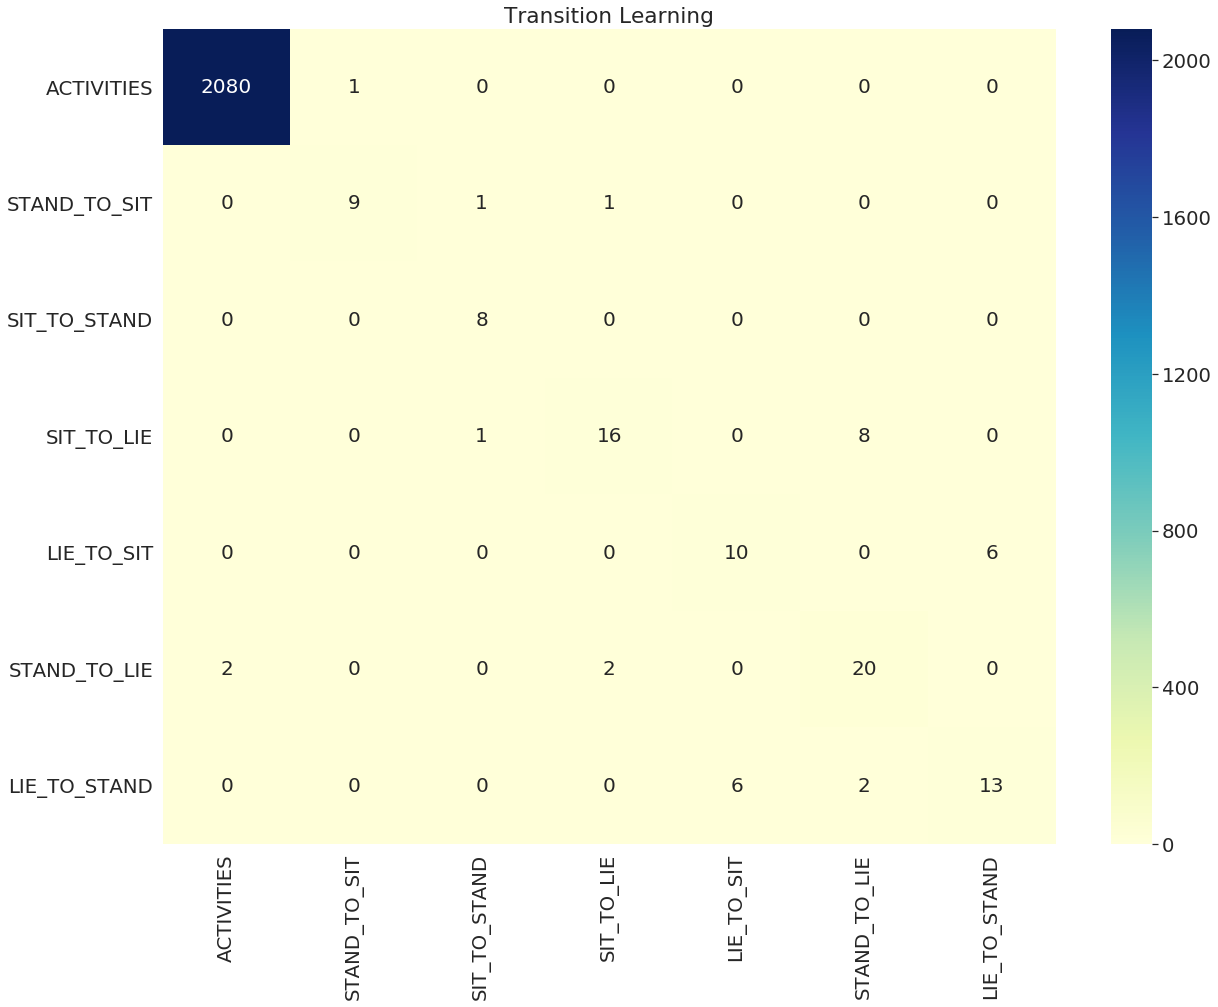

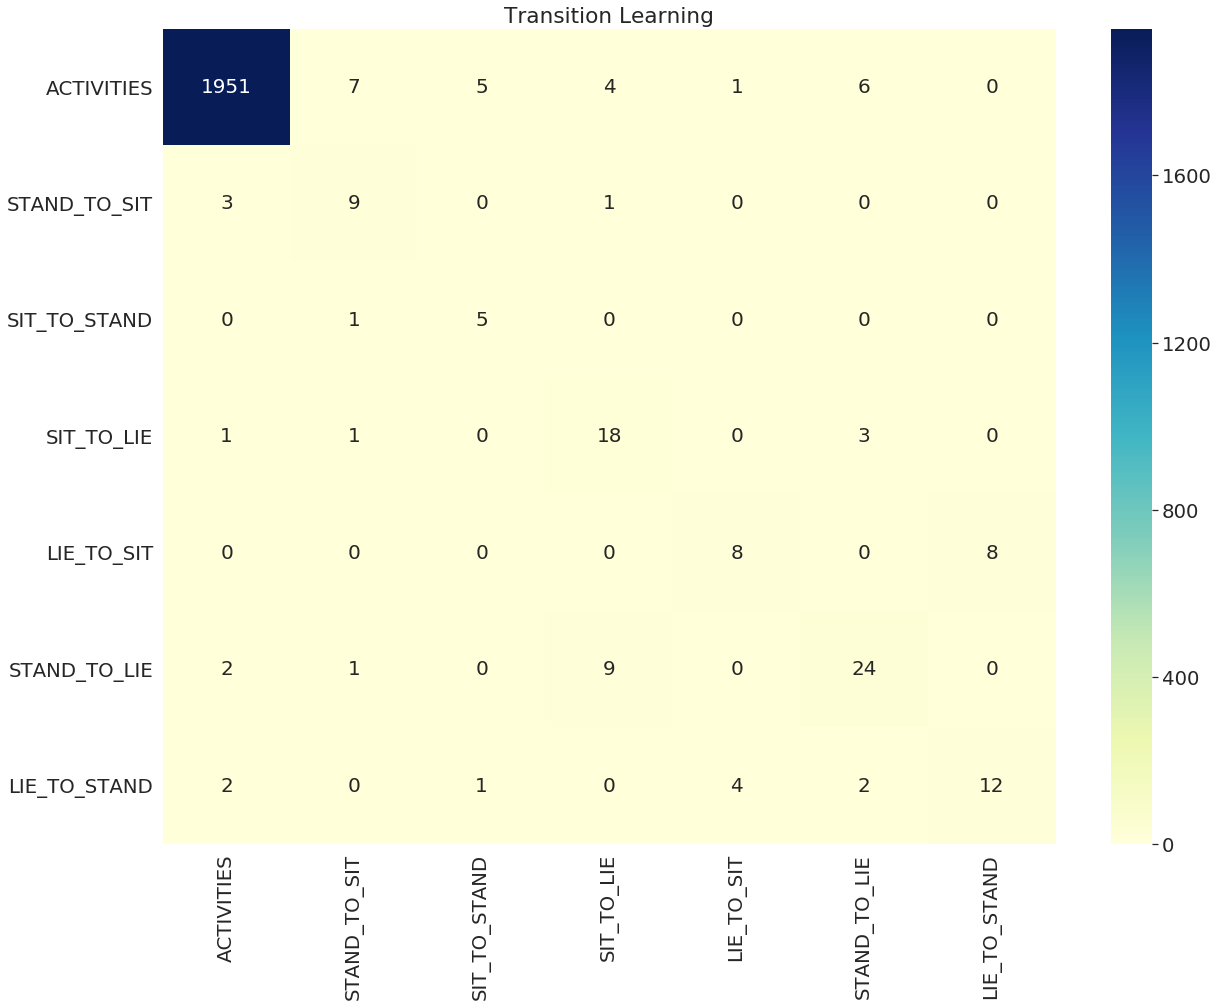

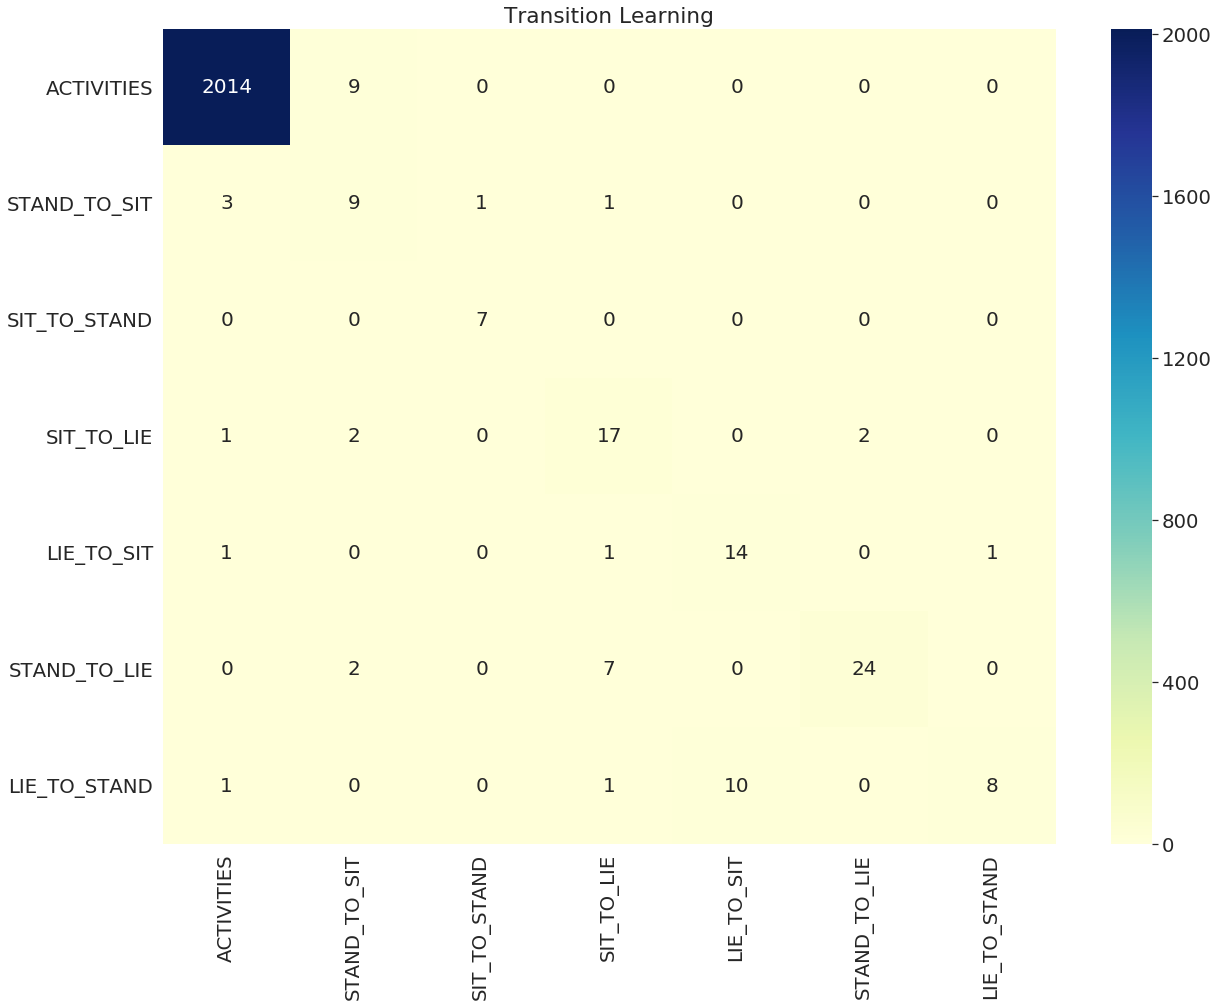

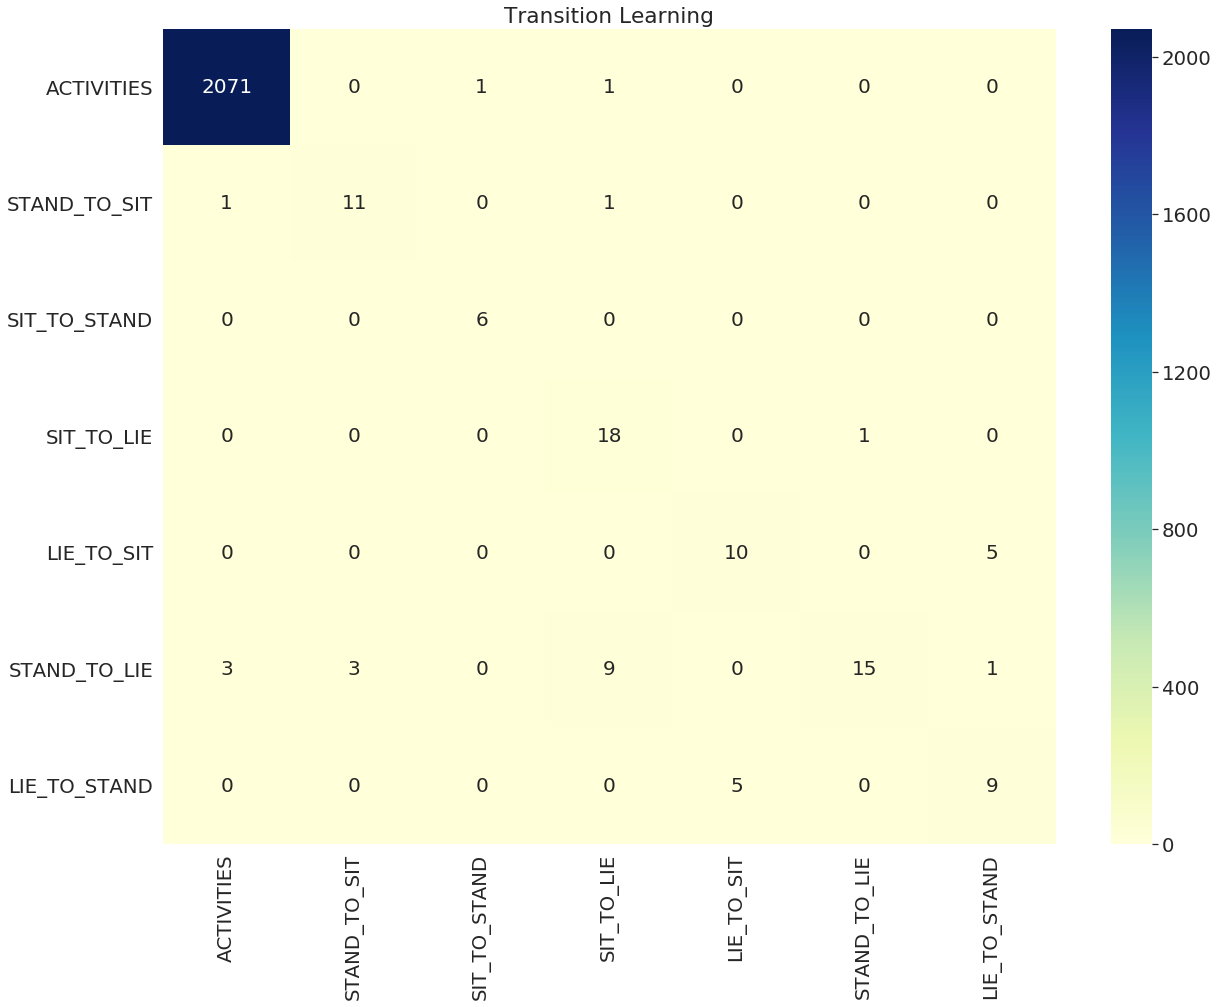

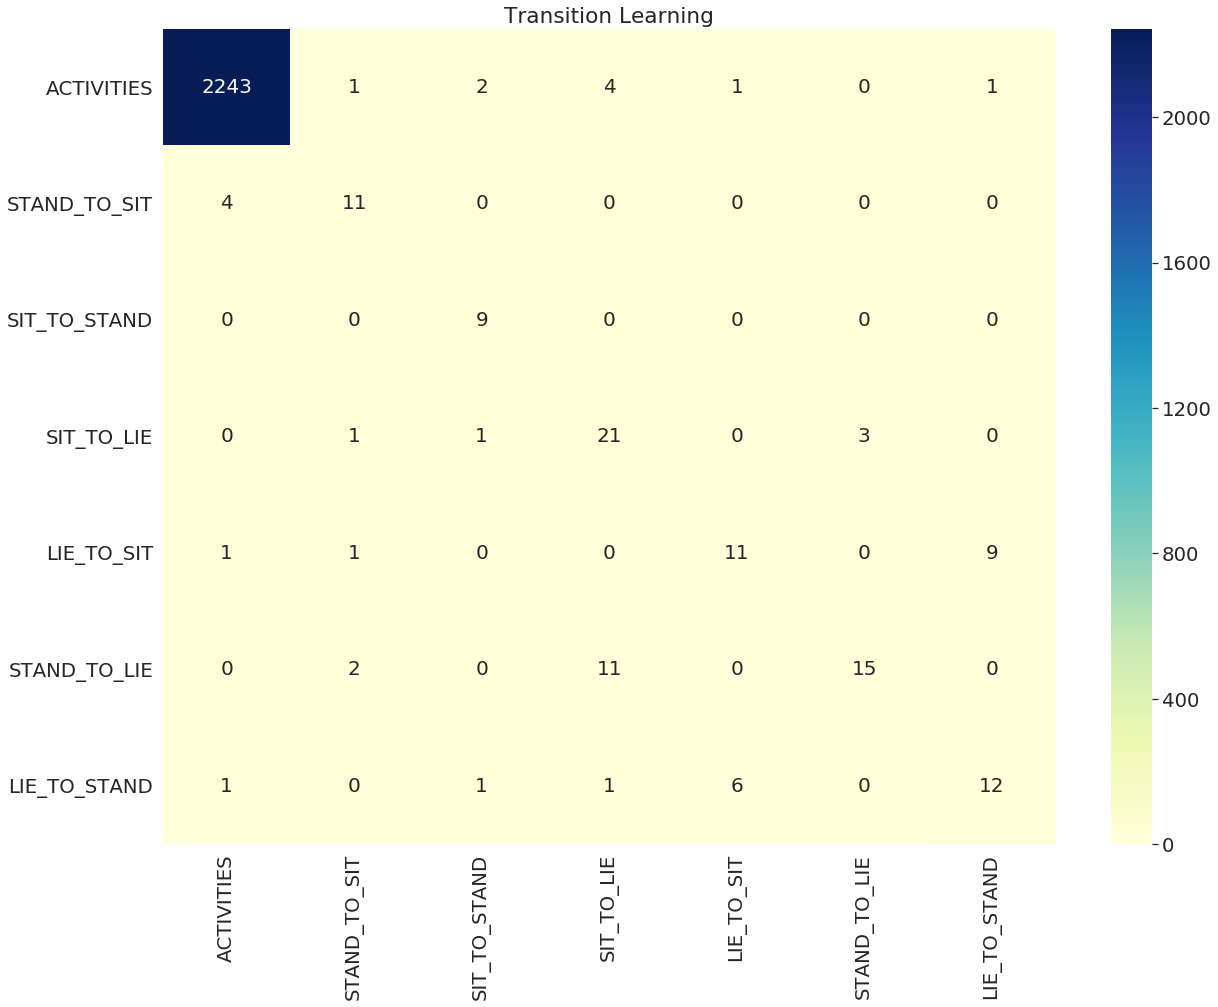

In [61]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, val_ids, test_ids = cv_fold[:int(0.6*len(cv_fold))], cv_fold[int(0.6*len(cv_fold)):int(0.8*len(cv_fold)):], cv_fold[int(0.8*len(cv_fold)):]

    train_idx = np.isin(user_ids, train_ids)
    val_idx = np.isin(user_ids, val_ids)
    test_idx = np.isin(user_ids, test_ids)
    
    X_transition_train=X[train_idx]
    X_transition_validation=X[val_idx]
    X_transition_test=X[test_idx]
    Y_transition_train=np.where(Y[train_idx] > 6, Y[train_idx], 0)
    Y_transition_validation=np.where(Y[val_idx] > 6, Y[val_idx], 0)
    Y_transition_test=np.where(Y[test_idx] > 6, Y[test_idx], 0)

    train_inp, train_out = X_transition_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
    val_inp, val_out = X_transition_validation, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
    test_inp, test_out = X_transition_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])
        
    train_gru(config, train_inp, train_out, val_inp, val_out)

In [ ]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 7
config["num_epochs"] = 5000
config["learning_rate"] = 1e-4

In [62]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_one_hot = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(activity_label_names)+1))
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_t.data.cpu().numpy(), axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((activity_label_names, np.vstack(results_metrics)))))
    with open("Activity_classification_results_BiGRU_paper_comp_2.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
    with open("Activity_classification_results_BiGRU_paper_comp_2_confusion_matrix.csv", 'a') as f:
        pd.DataFrame(np.hstack((activity_label_names.reshape(-1, 1), results_conf_mat))).to_csv(f, header=False)
             
    plt.subplots(figsize=(20,15))
    sns.set(font_scale = 1.8)
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=activity_label_names, yticklabels=activity_label_names)
    title="Activity Learning"
    s.set_title(title)

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.2582, device='cuda:0'))
(100, tensor(1.0649, device='cuda:0'))
(200, tensor(1.0355, device='cuda:0'))
(300, tensor(1.0247, device='cuda:0'))
(400, tensor(1.0189, device='cuda:0'))
(500, tensor(1.0151, device='cuda:0'))
(600, tensor(1.0124, device='cuda:0'))
(700, tensor(1.0104, device='cuda:0'))
(800, tensor(1.0087, device='cuda:0'))
(900, tensor(1.0071, device='cuda:0'))
(1000, tensor(1.0058, device='cuda:0'))
(1100, tensor(1.0045, device='cuda:0'))
(1200, tensor(1.0032, device='cuda:0'))
(1300, tensor(1.0020, device='cuda:0'))
(1400, tensor(1.0009, device='cuda:0'))
(1500, tensor(0.9998, device='cuda:0'))
(1600, tensor(0.9988, device='cuda:0'))
(1700, tensor(0.9979, device='cuda:0'))
(1800, tensor(0.9970, device='cuda:0'))
(1900, tensor(0.9962, device='cuda:0'))
(2000, tensor(0.9955, device='cuda:0'))
(2100, tensor(0.9949, device='cuda:0'))
(2200, tensor(0.9943, device='cuda:0'))
(2300, tensor(0.9937, device='cuda:0'))
(2400, tensor(0.9932, device='cuda:0'))
(2500, tenso

(700, tensor(1.0016, device='cuda:0'))
(800, tensor(0.9999, device='cuda:0'))
(900, tensor(0.9984, device='cuda:0'))
(1000, tensor(0.9970, device='cuda:0'))
(1100, tensor(0.9957, device='cuda:0'))
(1200, tensor(0.9944, device='cuda:0'))
(1300, tensor(0.9932, device='cuda:0'))
(1400, tensor(0.9920, device='cuda:0'))
(1500, tensor(0.9909, device='cuda:0'))
(1600, tensor(0.9898, device='cuda:0'))
(1700, tensor(0.9888, device='cuda:0'))
(1800, tensor(0.9879, device='cuda:0'))
(1900, tensor(0.9871, device='cuda:0'))
(2000, tensor(0.9864, device='cuda:0'))
(2100, tensor(0.9857, device='cuda:0'))
(2200, tensor(0.9850, device='cuda:0'))
(2300, tensor(0.9845, device='cuda:0'))
(2400, tensor(0.9840, device='cuda:0'))
(2500, tensor(0.9836, device='cuda:0'))
(2600, tensor(0.9832, device='cuda:0'))
(2700, tensor(0.9828, device='cuda:0'))
(2800, tensor(0.9825, device='cuda:0'))
(2900, tensor(0.9822, device='cuda:0'))
(3000, tensor(0.9820, device='cuda:0'))
(3100, tensor(0.9818, device='cuda:0'))
(32

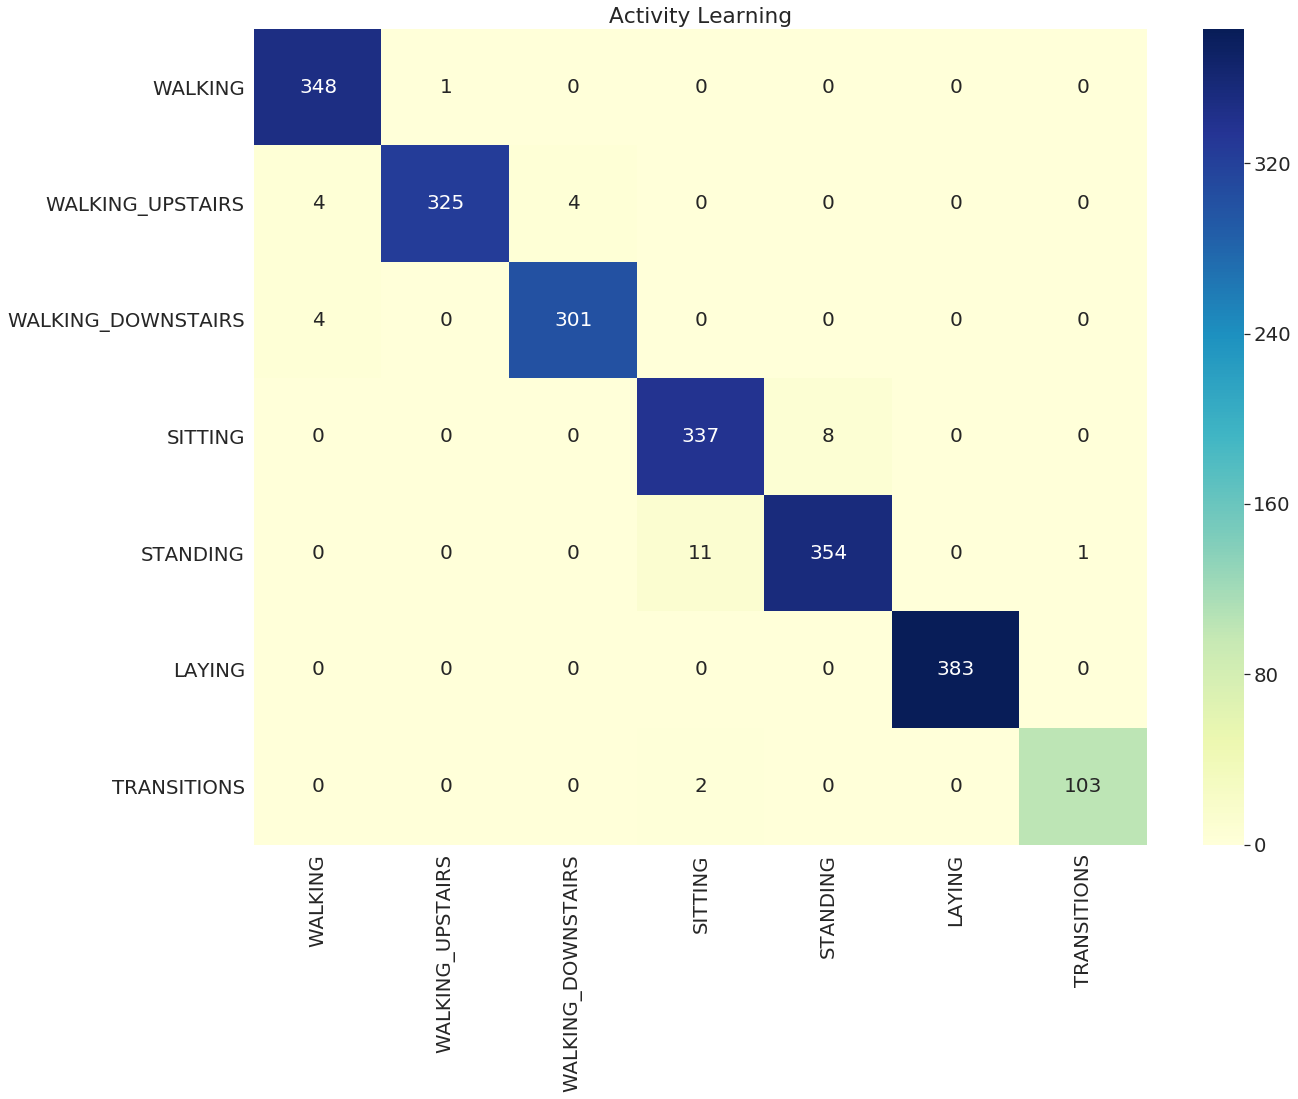

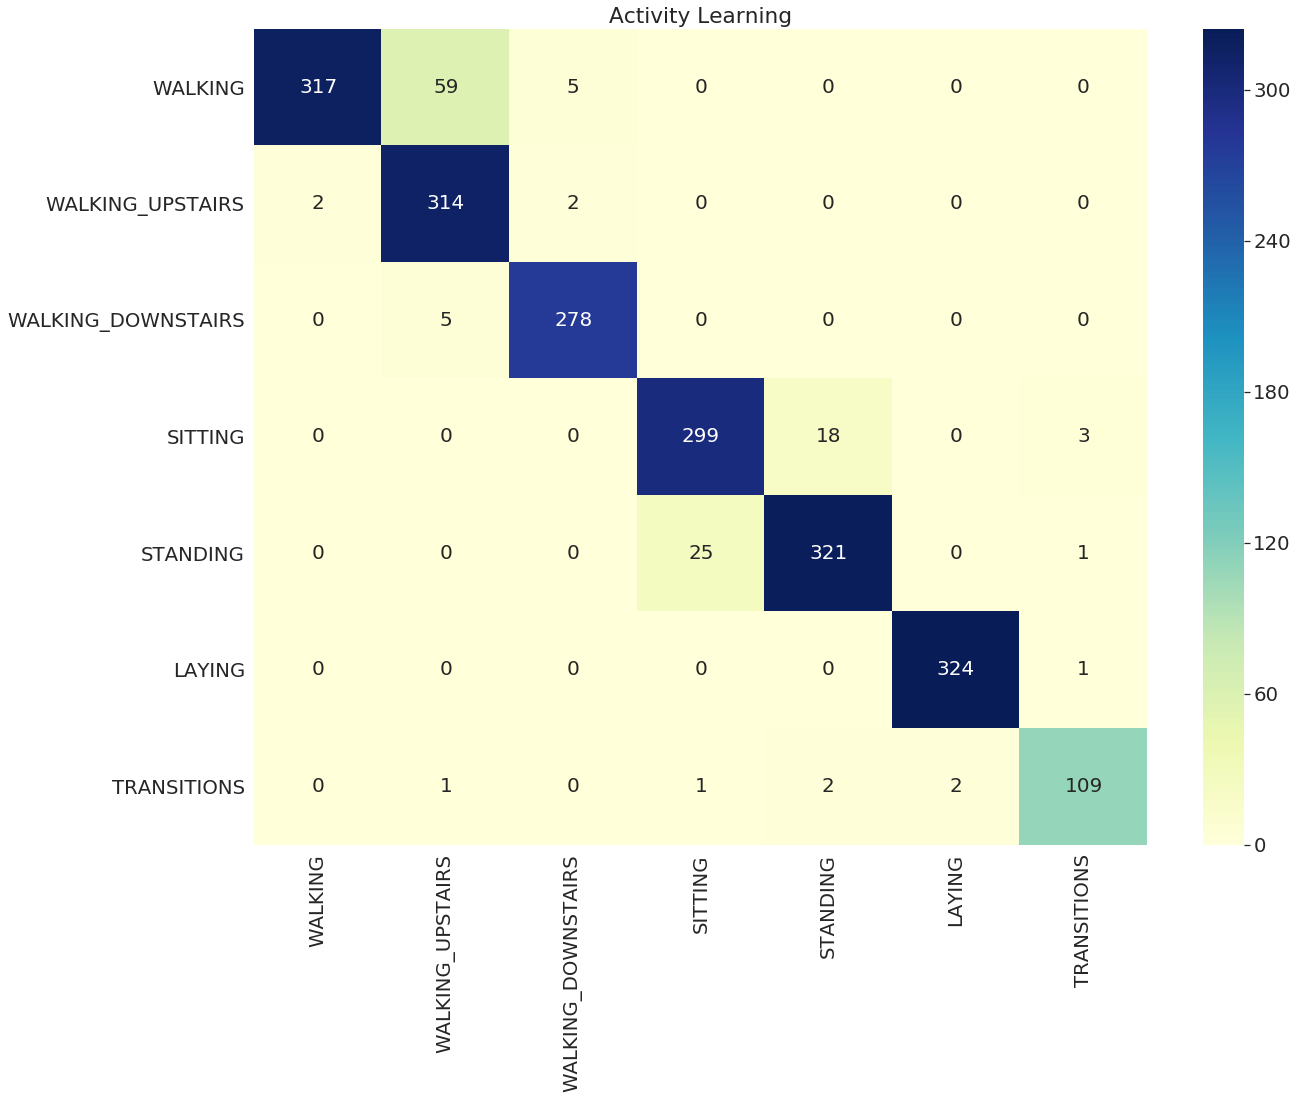

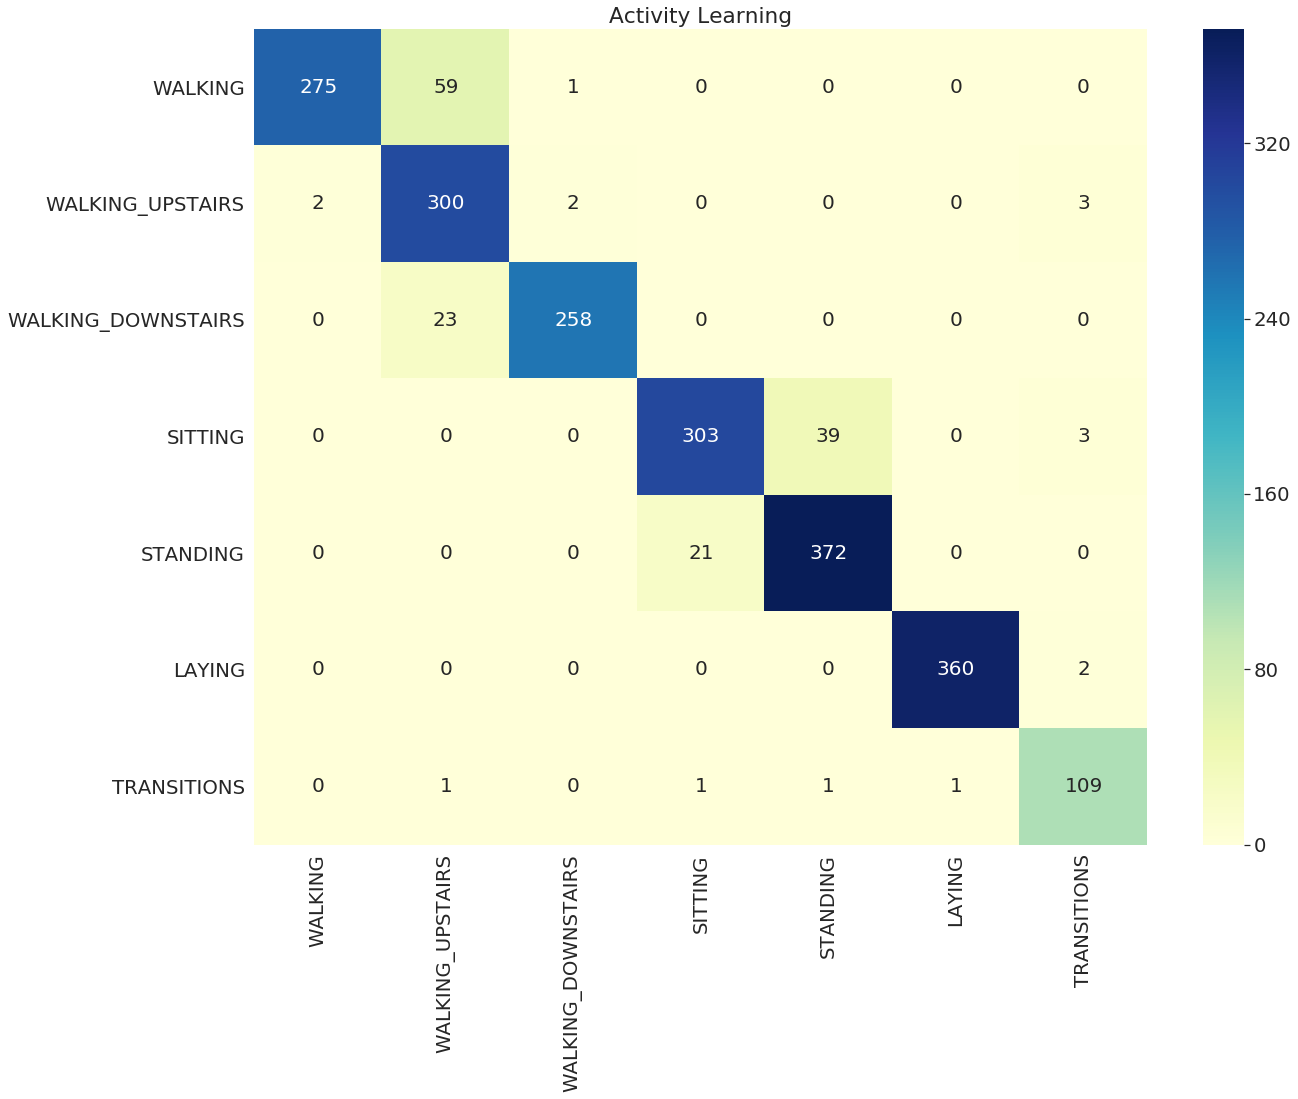

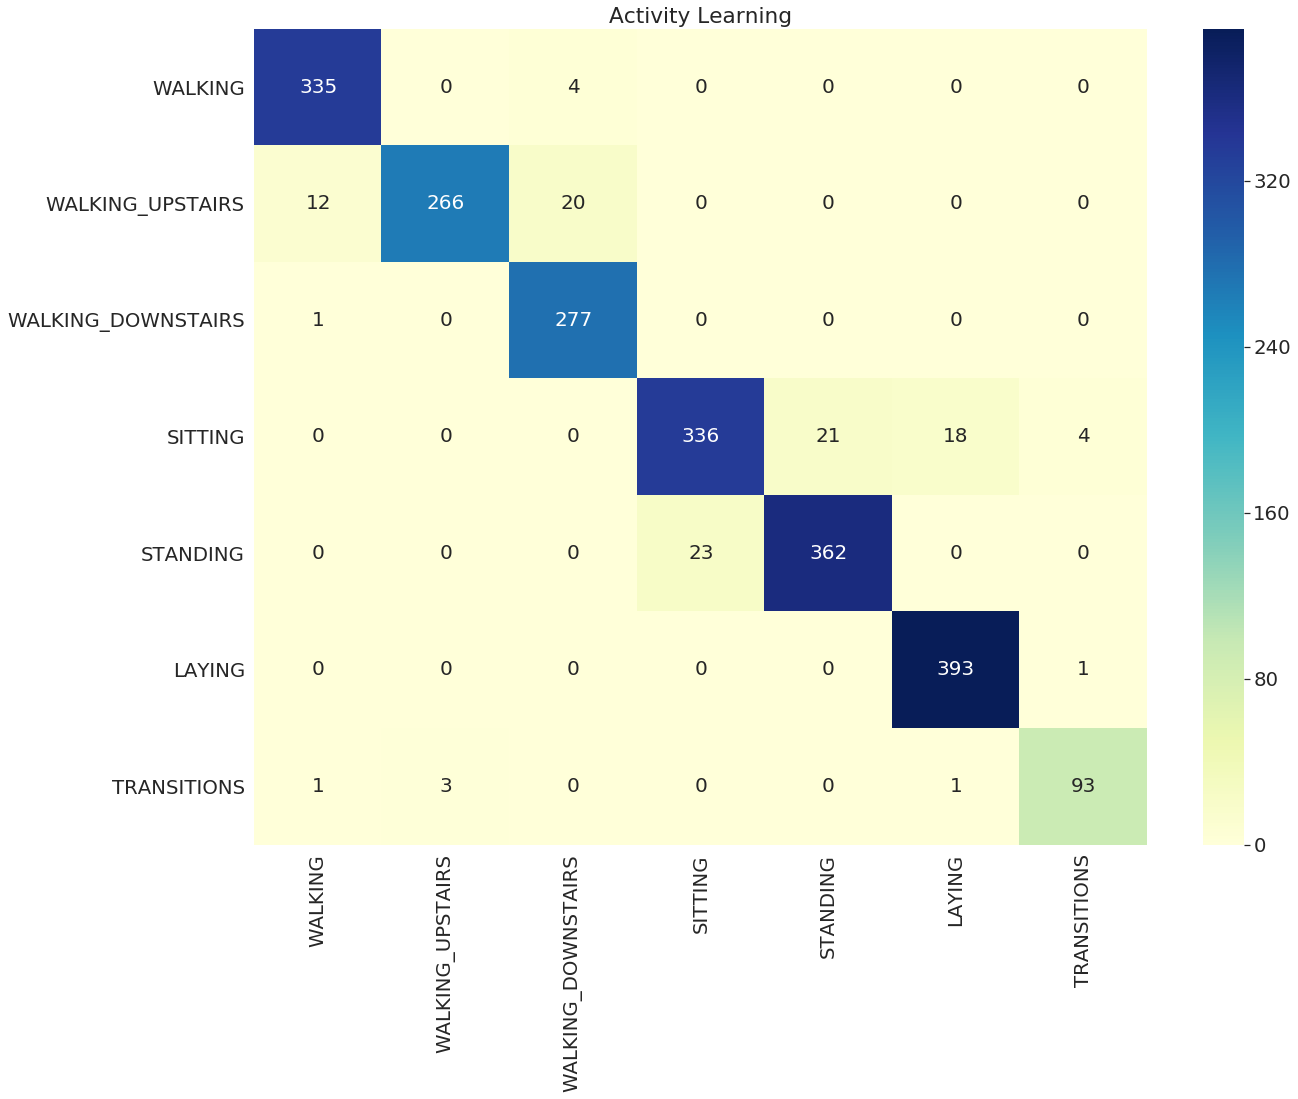

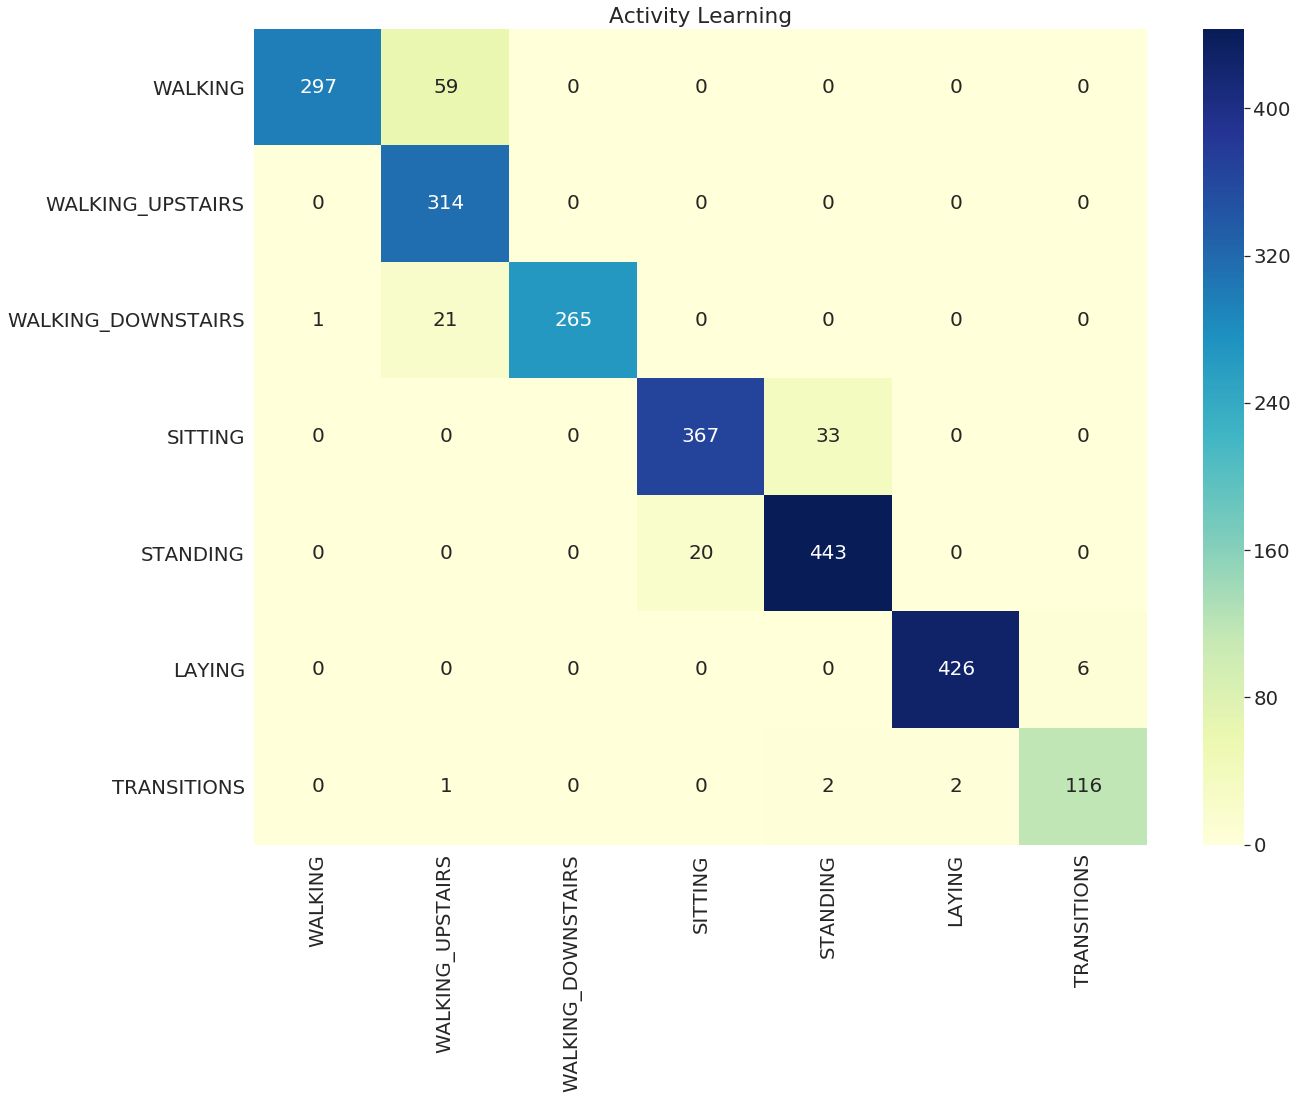

In [63]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, val_ids, test_ids = cv_fold[:int(0.6*len(cv_fold))], cv_fold[int(0.6*len(cv_fold)):int(0.8*len(cv_fold)):], cv_fold[int(0.8*len(cv_fold)):]

    train_idx = np.isin(user_ids, train_ids)
    val_idx = np.isin(user_ids, val_ids)
    test_idx = np.isin(user_ids, test_ids)
    
    X_activities_train=X[train_idx]
    X_activities_validation=X[val_idx]
    X_activities_test=X[test_idx]
    Y_activities_train=np.where(Y[train_idx] <= 6, Y[train_idx], 0)
    Y_activities_validation=np.where(Y[val_idx] <= 6, Y[val_idx], 0)
    Y_activities_test=np.where(Y[test_idx] <= 6, Y[test_idx], 0)

    train_inp, train_out = X_activities_train, one_hot(Y_activities_train, [1, 2, 3, 4, 5, 6, 0])
    val_inp, val_out = X_activities_validation, one_hot(Y_activities_validation, [1, 2, 3, 4, 5, 6, 0])
    test_inp, test_out = X_activities_test, one_hot(Y_activities_test, [1, 2, 3, 4, 5, 6, 0])
        
    train_gru(config, train_inp, train_out, val_inp, val_out)


In [64]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_numpy = pred_t.data.cpu().numpy()
    transition_act=np.where(np.argmax(pred_numpy, axis=1)==6, True, False)
    print(transition_act)
    groups = [(list(v), g) for g,v in itertools.groupby(transition_act)]
    processed=0
    transition_y_hat=[]
    #print(groups)
    for group in groups:
        cont=group[0]
        g=group[1]
        trans_pred=0
        if g:
            if(len(cont)>0):
                prev_act=np.argmax(pred_numpy[processed-1])+1
                next_act=np.argmax(pred_numpy[processed+len(cont)])+1
                if(prev_act==5 and next_act==4):
                    trans_pred=7
                elif(prev_act==5 and next_act==6):
                    trans_pred=11
                elif(prev_act==4 and next_act==5):
                    trans_pred=8
                elif(prev_act==4 and next_act==6):
                    trans_pred=9
                elif(prev_act==6 and next_act==4):
                    trans_pred=10
                elif(prev_act==6 and next_act==5):
                    #print("class 12 should be predicted")
                    trans_pred=12
                elif(prev_act==6 and next_act==1):
                    trans_pred=12
                else:
                    print("Unexpected Combination. Prev{}. Next{}".format(prev_act, next_act))
                processed+=len(cont)
            else:
                processed+=len(cont)
        else:
            processed+=len(cont)
        transition_y_hat.append(np.ones_like(cont)*trans_pred)
    transition_y_hat = np.hstack(transition_y_hat)
    
    pred_one_hot = one_hot(transition_y_hat, [0, 7, 8, 9, 10, 11, 12])
    
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_one_hot, axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate", "Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((transition_label_names, np.vstack(results_metrics)))))
    with open("negative_activity_transition_classification_results_BiGRU_paper_comp_2.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
    with open("negative_activity_transition_classification_results_BiGRU_paper_comp_2_conf_matrix.csv", 'a') as f:    
        pd.DataFrame(np.hstack((transition_label_names.reshape(-1, 1), results_conf_mat))).to_csv(f, header=False)
    plt.subplots(figsize=(20,15))
    sns.set(font_scale = 1.8)
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=transition_label_names, yticklabels=transition_label_names)
    title="Transition Learning"
    s.set_title(title)

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.2610, device='cuda:0'))
(100, tensor(1.0648, device='cuda:0'))
(200, tensor(1.0355, device='cuda:0'))
(300, tensor(1.0248, device='cuda:0'))
(400, tensor(1.0189, device='cuda:0'))
(500, tensor(1.0152, device='cuda:0'))
(600, tensor(1.0125, device='cuda:0'))
(700, tensor(1.0105, device='cuda:0'))
(800, tensor(1.0088, device='cuda:0'))
(900, tensor(1.0073, device='cuda:0'))
(1000, tensor(1.0059, device='cuda:0'))
(1100, tensor(1.0046, device='cuda:0'))
(1200, tensor(1.0034, device='cuda:0'))
(1300, tensor(1.0023, device='cuda:0'))
(1400, tensor(1.0012, device='cuda:0'))
(1500, tensor(1.0001, device='cuda:0'))
(1600, tensor(0.9991, device='cuda:0'))
(1700, tensor(0.9981, device='cuda:0'))
(1800, tensor(0.9973, device='cuda:0'))
(1900, tensor(0.9964, device='cuda:0'))
(2000, tensor(0.9957, device='cuda:0'))
(2100, tensor(0.9950, device='cuda:0'))
(2200, tensor(0.9944, device='cuda:0'))
(2300, tensor(0.9938, device='cuda:0'))
(2400, tensor(0.9933, device='cuda:0'))
(2500, tenso

(4100, tensor(0.9859, device='cuda:0'))
(4200, tensor(0.9858, device='cuda:0'))
(4300, tensor(0.9858, device='cuda:0'))
(4400, tensor(0.9857, device='cuda:0'))
(4500, tensor(0.9857, device='cuda:0'))
(4600, tensor(0.9857, device='cuda:0'))
(4700, tensor(0.9856, device='cuda:0'))
(4800, tensor(0.9856, device='cuda:0'))
(4900, tensor(0.9856, device='cuda:0'))
[False False False ... False False False]
something broke. Prev5. Next5
something broke. Prev1. Next6
class 12 should be predicted
something broke. Prev2. Next4
something broke. Prev4. Next4
something broke. Prev2. Next2
something broke. Prev5. Next5
(0, tensor(1.2490, device='cuda:0'))
(100, tensor(1.0548, device='cuda:0'))
(200, tensor(1.0252, device='cuda:0'))
(300, tensor(1.0149, device='cuda:0'))
(400, tensor(1.0095, device='cuda:0'))
(500, tensor(1.0060, device='cuda:0'))
(600, tensor(1.0034, device='cuda:0'))
(700, tensor(1.0014, device='cuda:0'))
(800, tensor(0.9998, device='cuda:0'))
(900, tensor(0.9983, device='cuda:0'))
(

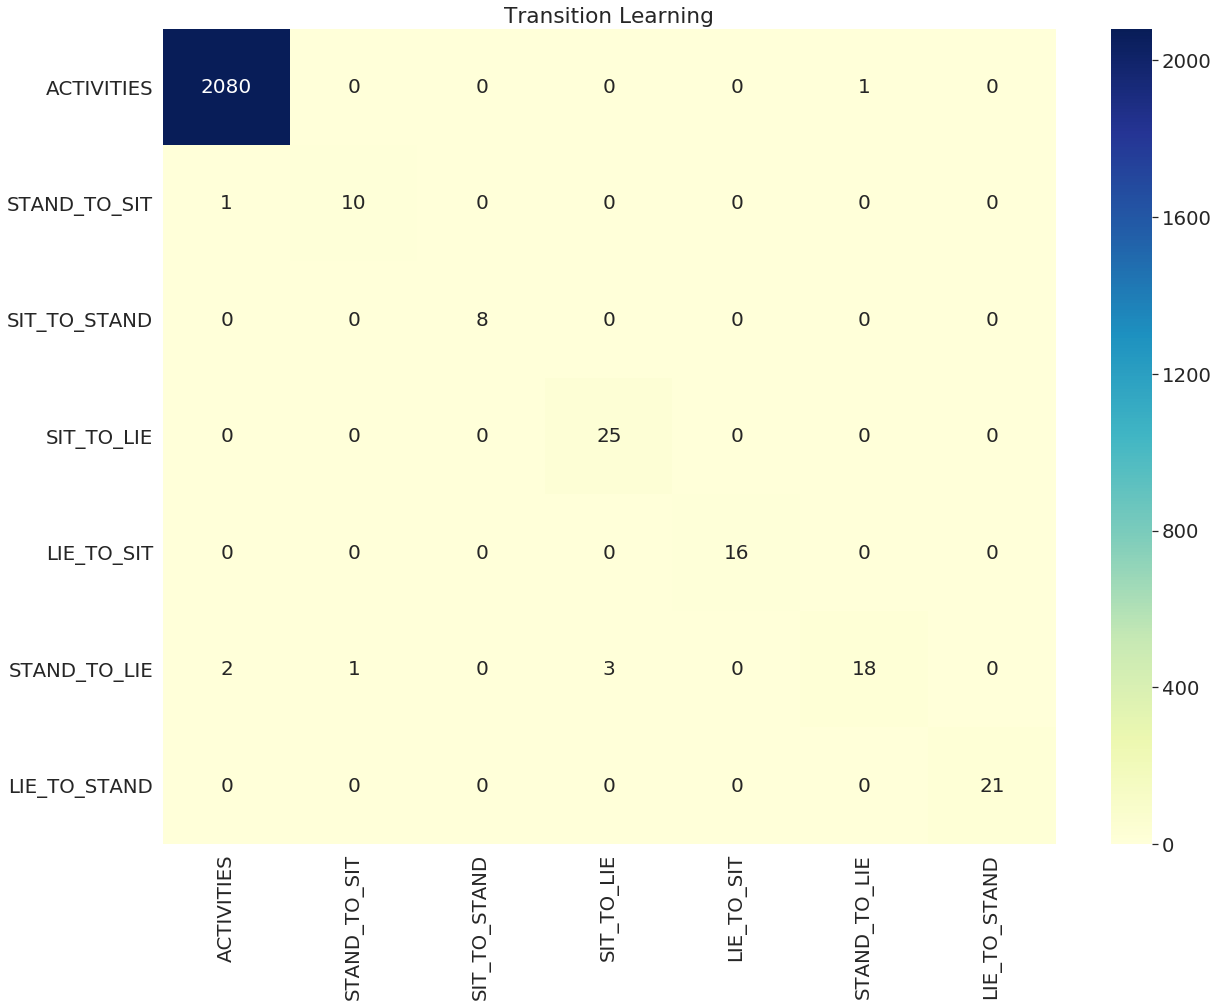

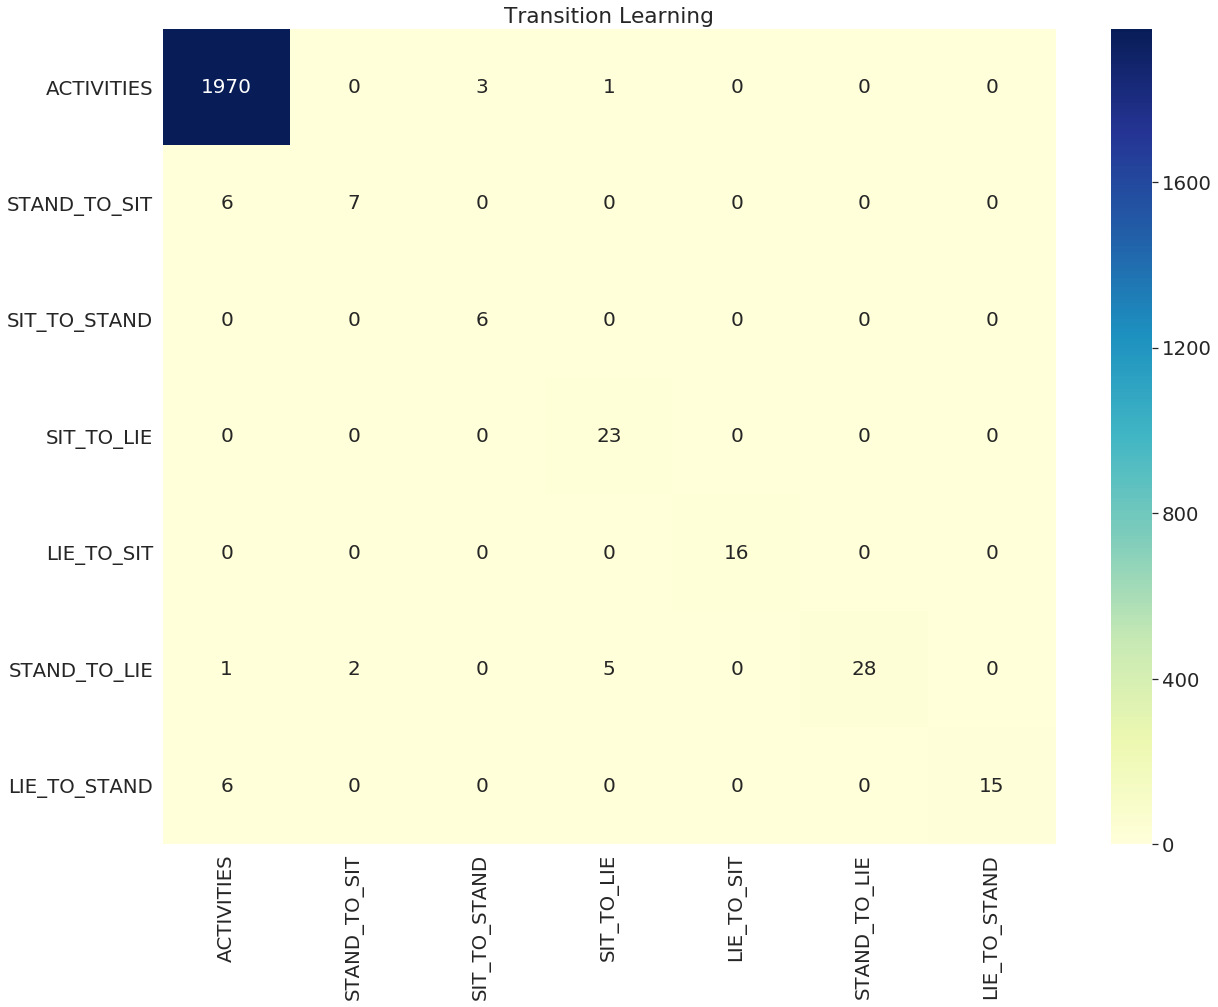

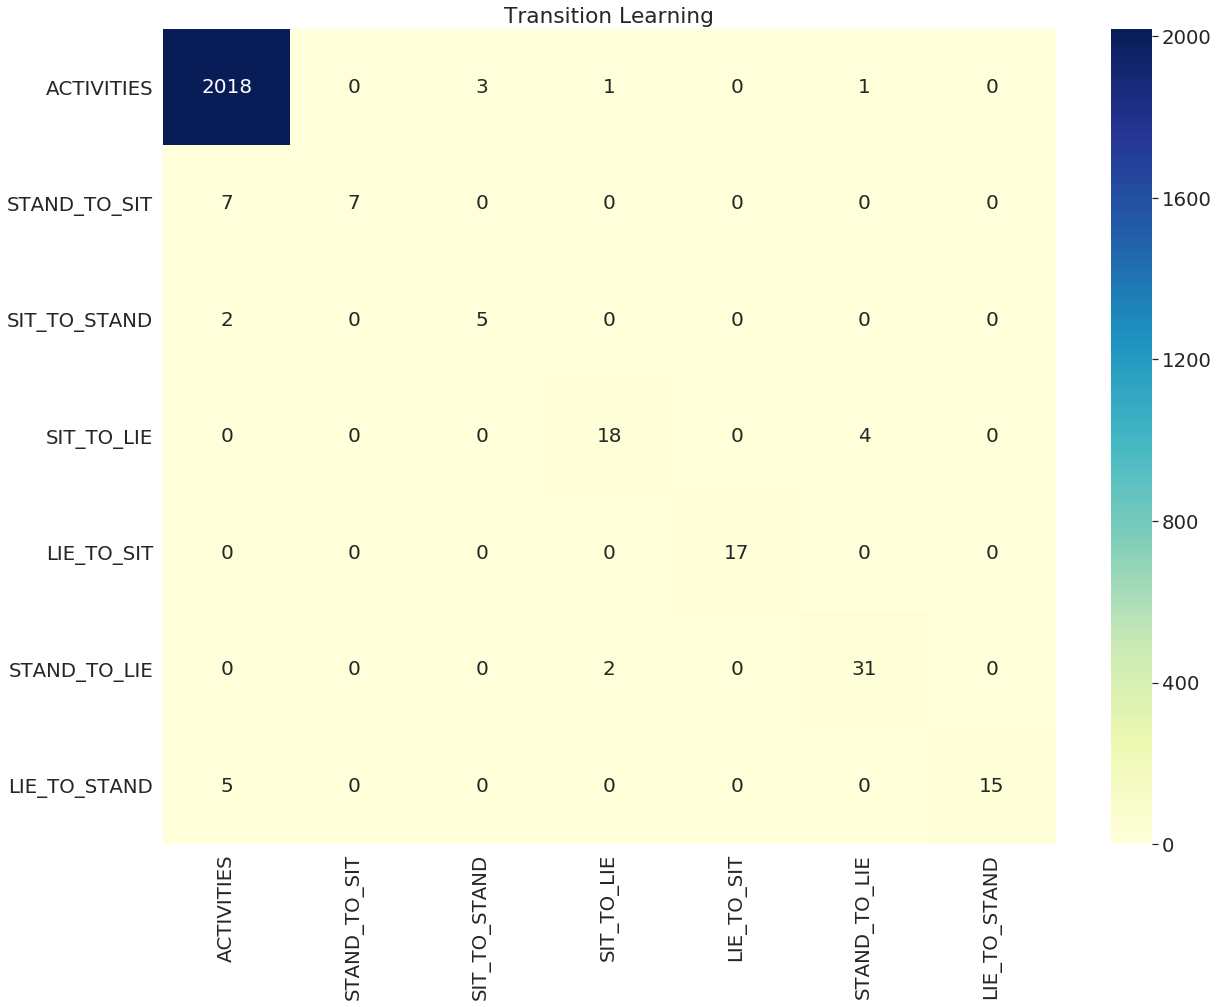

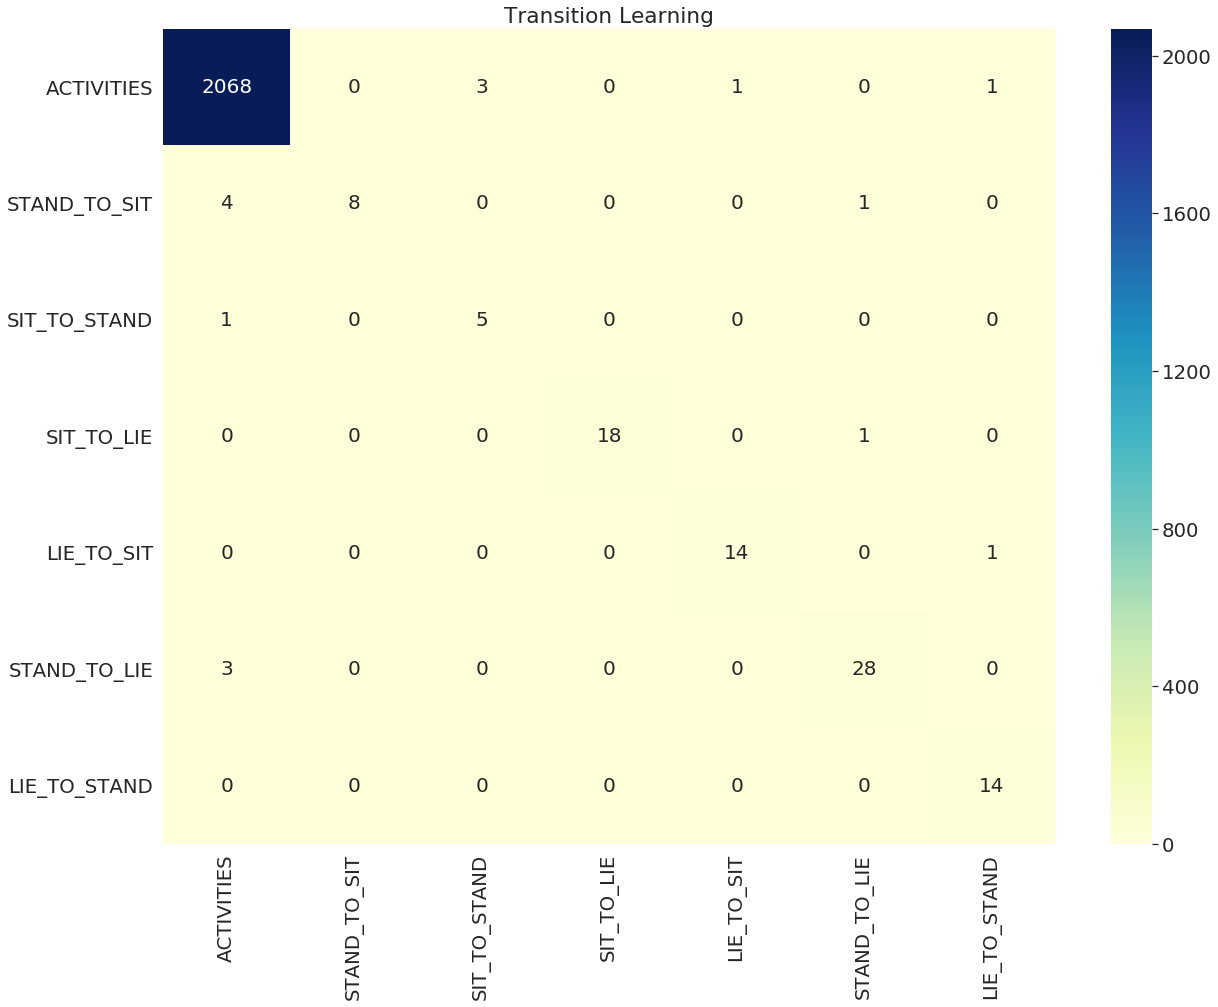

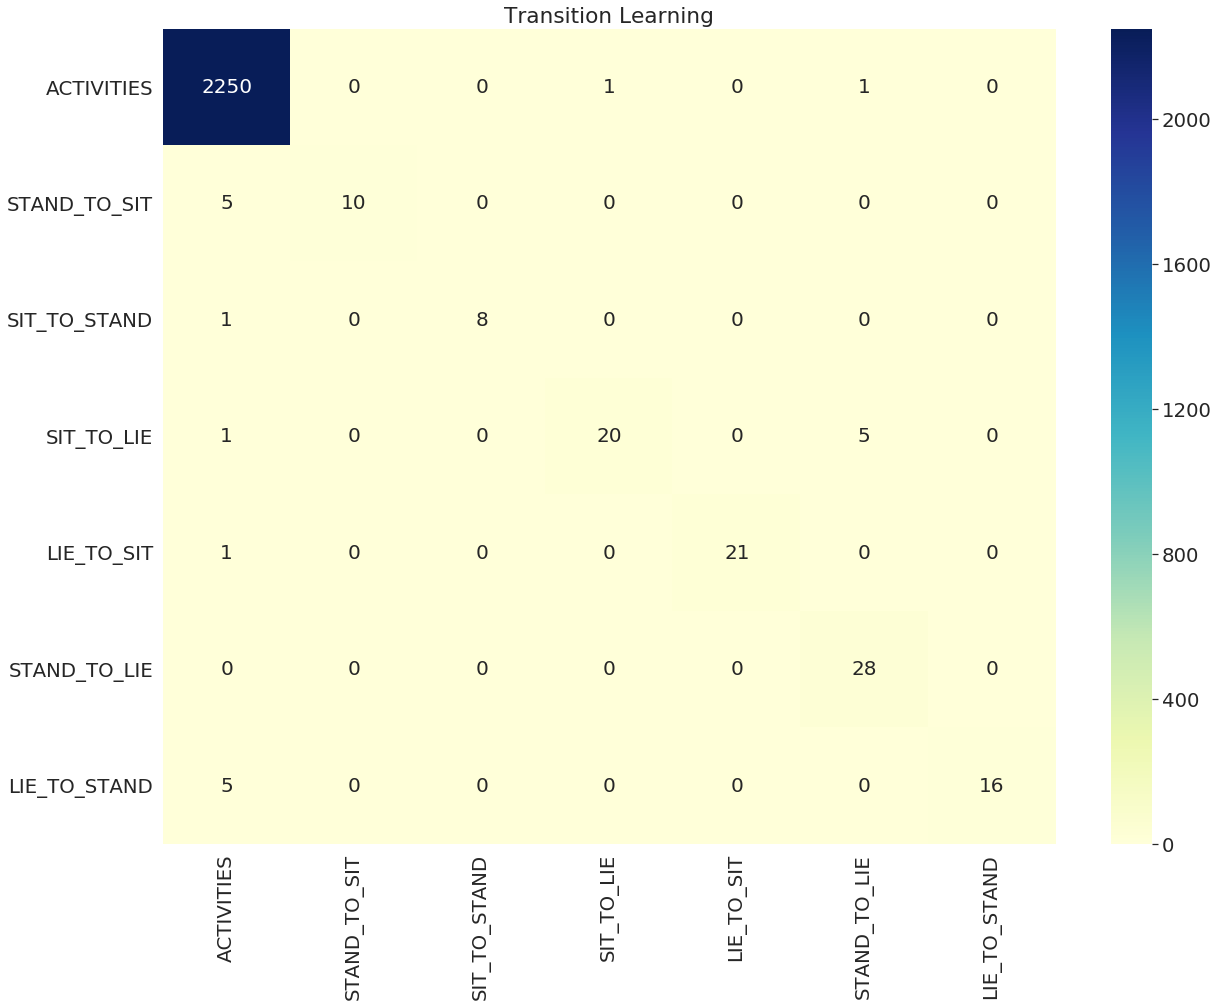

In [65]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, val_ids, test_ids = cv_fold[:int(0.6*len(cv_fold))], cv_fold[int(0.6*len(cv_fold)):int(0.8*len(cv_fold)):], cv_fold[int(0.8*len(cv_fold)):]

    train_idx = np.isin(user_ids, train_ids)
    val_idx = np.isin(user_ids, val_ids)
    test_idx = np.isin(user_ids, test_ids)
    
    X_activity_train=X[train_idx]
    X_activity_validation=X[val_idx]
    X_activity_test=X[test_idx]
    Y_activity_train=np.where(Y[train_idx] <= 6, Y[train_idx], 0)
    Y_activity_validation=np.where(Y[val_idx] <= 6, Y[val_idx], 0)
    Y_activity_test=np.where(Y[test_idx] <= 6, Y[test_idx], 0)
    
    X_transition_train=X[train_idx]
    X_transition_validation=X[val_idx]
    X_transition_test=X[test_idx]
    Y_transition_train=np.where(Y[train_idx] > 6, Y[train_idx], 0)
    Y_transition_validation=np.where(Y[val_idx] > 6, Y[val_idx], 0)
    Y_transition_test=np.where(Y[test_idx] > 6, Y[test_idx], 0)
        
    train_act_inp, train_act_out = X_activity_train, one_hot(Y_activity_train, [1, 2, 3, 4, 5, 6, 0])
    val_act_inp, val_act_out = X_activity_validation, one_hot(Y_activity_validation, [1, 2, 3, 4, 5, 6, 0])
    test_act_inp, test_act_out = X_activity_test, one_hot(Y_activity_test, [1, 2, 3, 4, 5, 6, 0])
    
    train_trans_inp, train_trans_out = X_transition_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
    val_trans_inp, val_trans_out = X_transition_validation, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
    test_trans_inp, test_trans_out = X_transition_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])

    train_gru(config, train_act_inp, train_act_out, val_act_inp, val_trans_out)
    

In [ ]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_one_hot = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(label_names)+1))
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_t.data.cpu().numpy(), axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((label_names, np.vstack(results_metrics)))))
    with open("BiGRU_Baseline_all_5000_w_validation.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
             
    plt.subplots(figsize=(20,15))
    s=seaborn.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=label_names, yticklabels=label_names)
    title="Activity Transition Learning"
    s.set_title(title)
    

In [ ]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 12
config["num_epochs"] = 5000
config["learning_rate"] = 1e-4

In [ ]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, val_ids, test_ids = cv_fold[:int(0.6*len(cv_fold))], cv_fold[int(0.6*len(cv_fold)):int(0.8*len(cv_fold)):], cv_fold[int(0.8*len(cv_fold)):]

    train_idx = np.isin(user_ids, train_ids)
    val_idx = np.isin(user_ids, val_ids)
    test_idx = np.isin(user_ids, test_ids)
    
    X_transition_train=X[train_idx]
    X_transition_validation=X[val_idx]
    X_transition_test=X[test_idx]
    Y_transition_train=Y[train_idx]
    Y_transition_validation=Y[val_idx]
    Y_transition_test=Y[test_idx]

    train_inp, train_out = X_transition_train, one_hot(Y_transition_train, [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])
    val_inp, val_out = X_transition_validation, one_hot(Y_transition_validation, [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])
    test_inp, test_out = X_transition_test, one_hot(Y_transition_test, [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])
    
    print(train_out.shape)
    print(val_out.shape)
    train_gru(config, train_inp, train_out, val_inp, val_out)